# VacationPy
---

## Starter Code to Import Libraries and Load the Weather and Coordinates Data

In [2]:
# Dependencies and Setup
import hvplot.pandas
import pandas as pd
import requests


# Import API key
from api_keys import geoapify_key

In [3]:
# Load the CSV file created in Part 1 into a Pandas DataFrame
city_data_df = pd.read_csv("output_data/cities.csv")

# Display sample data
city_data_df.head()

,City_ID,City,Lat,Lng,Max Temp,Humidity,Cloudiness,Wind Speed,Country,Date
0,0,hawaiian paradise park,19.5933,-154.9731,28.73,76,20,5.14,US,1697580697
1,1,olyokminsk,60.3736,120.4264,1.11,67,96,3.58,RU,1697580698
2,2,sumusta as sultani,28.9167,30.8500,22.50,58,5,4.02,EG,1697580698
3,3,alofi,-19.0595,-169.9187,25.94,53,40,9.77,NU,1697580699
4,4,adamstown,-25.0660,-130.1015,22.40,85,100,4.47,PN,1697580699


---

### Step 1: Create a map that displays a point for every city in the `city_data_df` DataFrame. The size of the point should be the humidity in each city.

In [17]:
%%capture --no-display

# Configure the map plot
map_plot_humidity = city_data_df.hvplot.points(
    "Lng",
    "Lat",
    geo = True,
    tiles = "CartoDark",
    frame_width = 700,
    frame_height = 500,
    size = "Humidity",
    scale = .5,
    color = "City"
)

# Display the map
map_plot_humidity

:Overlay
   .Tiles.I  :Tiles   [x,y]
   .Points.I :Points   [Lng,Lat]   (City,Humidity)

### Step 2: Narrow down the `city_data_df` DataFrame to find your ideal weather condition

In [5]:
# Narrow down cities that fit criteria and drop any results with null values
# ChatGPT
ideal_city_data_df = city_data_df[(city_data_df["Humidity"] < 55) & (city_data_df["Max Temp"] < 27)]

# Drop any rows with null values
# https://github.com/pandas-dev/pandas/blob/main/doc/cheatsheet/Pandas_Cheat_Sheet.pdf
ideal_city_data_df.dropna()

# Display sample data
ideal_city_data_df

,City_ID,City,Lat,Lng,Max Temp,Humidity,Cloudiness,Wind Speed,Country,Date
3,3,alofi,-19.0595,-169.9187,25.94,53,40,9.77,NU,1697580699
19,19,urzhar,47.0930,81.6294,8.39,39,3,1.42,KZ,1697580708
23,23,la ronge,55.1001,-105.2842,16.14,41,100,2.57,CA,1697580710
25,25,crawfordsville,40.0411,-86.8745,17.13,47,40,2.06,US,1697580713
48,48,ghanzi,-21.5667,21.7833,20.29,24,0,3.98,BW,1697580728
...,...,...,...,...,...,...,...,...,...,...
539,539,beaufort west,-32.3567,22.5830,20.77,27,0,0.91,ZA,1697581021
551,551,moose jaw,50.4001,-105.5344,21.14,21,40,10.29,CA,1697581028
554,554,tallulah,32.4085,-91.1868,23.03,31,0,0.00,US,1697581029
557,557,al faw,29.9776,48.4741,24.00,36,15,4.24,IQ,1697581030


### Step 3: Create a new DataFrame called `hotel_df`.

In [6]:
# Use the Pandas copy function to create DataFrame called hotel_df to store the city, country, coordinates, and humidity
# ChatGPT
hotel_df = ideal_city_data_df.copy()
hotel_df = hotel_df[["City", "Country", "Lat", "Lng", "Humidity"]]
# Add an empty column, "Hotel Name," to the DataFrame so you can store the hotel found using the Geoapify API
hotel_df["Hotel Name"] = ""

# Display sample data
hotel_df

,City,Country,Lat,Lng,Humidity,Hotel Name
3,alofi,NU,-19.0595,-169.9187,53,
19,urzhar,KZ,47.0930,81.6294,39,
23,la ronge,CA,55.1001,-105.2842,41,
25,crawfordsville,US,40.0411,-86.8745,47,
48,ghanzi,BW,-21.5667,21.7833,24,
...,...,...,...,...,...,...
539,beaufort west,ZA,-32.3567,22.5830,27,
551,moose jaw,CA,50.4001,-105.5344,21,
554,tallulah,US,32.4085,-91.1868,31,
557,al faw,IQ,29.9776,48.4741,36,


### Step 4: For each city, use the Geoapify API to find the first hotel located within 10,000 metres of your coordinates.

In [7]:
# Set parameters to search for a hotel
# ChatGPT

categories = "accommodation.hotel"
limit = 20
radius = 10000
params = {
    "categories":categories,
    "limit":limit,
    "apiKey":geoapify_key
}

# Print a message to follow up the hotel search
print("Starting hotel search")

# Iterate through the hotel_df DataFrame
for index, row in hotel_df.iterrows():
    # get latitude, longitude from the DataFrame
    lng = row["Lng"]
    lat = row["Lat"]
    
    # Add filter and bias parameters with the current city's latitude and longitude to the params dictionary
    params["filter"] = f"circle:{lng},{lat},{radius}"
    params["bias"] = f"proximity:{lng},{lat}"
    
    # Set base URL
    base_url = "https://api.geoapify.com/v2/places"


    # Make and API request using the params dictionaty
    # Convert the API response to JSON format
    name_address = requests.get(base_url, params=params).json()
    
    # Grab the first hotel from the results and store the name in the hotel_df DataFrame
    try:
        hotel_df.loc[index, "Hotel Name"] = name_address["features"][0]["properties"]["name"]
    except (KeyError, IndexError):
        # If no hotel is found, set the hotel name as "No hotel found".
        hotel_df.loc[index, "Hotel Name"] = "No hotel found"
        
    # Log the search results
    print(f"{hotel_df.loc[index, 'City']} - nearest hotel: {hotel_df.loc[index, 'Hotel Name']}")

# Display sample data
hotel_df

Starting hotel search
alofi - nearest hotel: Matavai Resort
urzhar - nearest hotel: Sharikan
la ronge - nearest hotel: La Ronge Hotel and Suites
crawfordsville - nearest hotel: Quality Inn
ghanzi - nearest hotel: Ghanzi farmhouse
centenario - nearest hotel: Hotel Global
san julian - nearest hotel: No hotel found
ad dabbah - nearest hotel: No hotel found
dryden - nearest hotel: Holiday Inn Express
qorovulbozor - nearest hotel: узпаравтотранс
santa maria ajoloapan - nearest hotel: No hotel found
oruro - nearest hotel: Hotel Edén
khuzdar - nearest hotel: Al-Mustafa hotel
kuqa - nearest hotel: Kuqa Hotel - foreigners accepted
san patricio - nearest hotel: No hotel found
mount isa - nearest hotel: Ibis Styles
comodoro rivadavia - nearest hotel: No hotel found
kot samaba - nearest hotel: No hotel found
turpan - nearest hotel: Oriental
mercedes - nearest hotel: Gran Hotel Mercedes
turkestan - nearest hotel: Атамекен
viedma - nearest hotel: Níjar
buka - nearest hotel: No hotel found
aksu - nea

,City,Country,Lat,Lng,Humidity,Hotel Name
3,alofi,NU,-19.0595,-169.9187,53,Matavai Resort
19,urzhar,KZ,47.0930,81.6294,39,Sharikan
23,la ronge,CA,55.1001,-105.2842,41,La Ronge Hotel and Suites
25,crawfordsville,US,40.0411,-86.8745,47,Quality Inn
48,ghanzi,BW,-21.5667,21.7833,24,Ghanzi farmhouse
...,...,...,...,...,...,...
539,beaufort west,ZA,-32.3567,22.5830,27,Matoppo Inn
551,moose jaw,CA,50.4001,-105.5344,21,Temple Gardens Mineral Spa Resort
554,tallulah,US,32.4085,-91.1868,31,No hotel found
557,al faw,IQ,29.9776,48.4741,36,No hotel found


### Step 5: Add the hotel name and the country as additional information in the hover message for each city in the map.

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
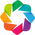

:Overlay
   .Tiles.I  :Tiles   [x,y]
   .Points.I :Points   [Lng,Lat]   (City,Humidity,Country,Hotel Name)

In [18]:
%%capture --no-display

import holoviews as hv
hv.extension('bokeh')

# Configure the map plot
# ChatGPT
map_plot_hotel = hotel_df.hvplot.points(
    "Lng",
    "Lat",
    geo = True,
    tiles = "CartoDark",
    frame_width = 1000,
    frame_height = 700,
    size = "Humidity",
    scale = 2,
    color = "City",
    hover_cols = ["Country", "Hotel Name"]
)

# Display the map
map_plot_hotel